# Explore here

In [1]:
# lectura de los datos
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [3]:
#cambiar el formato de date a date_time
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    366 non-null    datetime64[ns]
 1   sales   366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


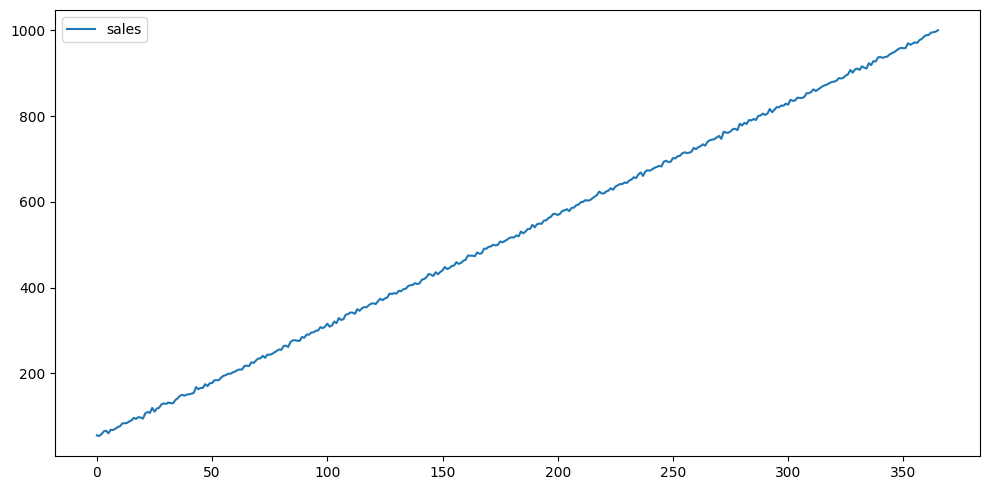

In [6]:
#graficar la serie de tiempo
import matplotlib.pyplot as plt
import seaborn as sns

#para visualizar mejor, le damos un figsize
plt.subplots(figsize=(10,5))
sns.lineplot(data=df)
plt.tight_layout()
plt.show()

In [9]:
#df['date'] = df['date'].dt.date
df = df.set_index('date')
#revisar set index

In [10]:
#descomponer la serie. 
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df, period=30)

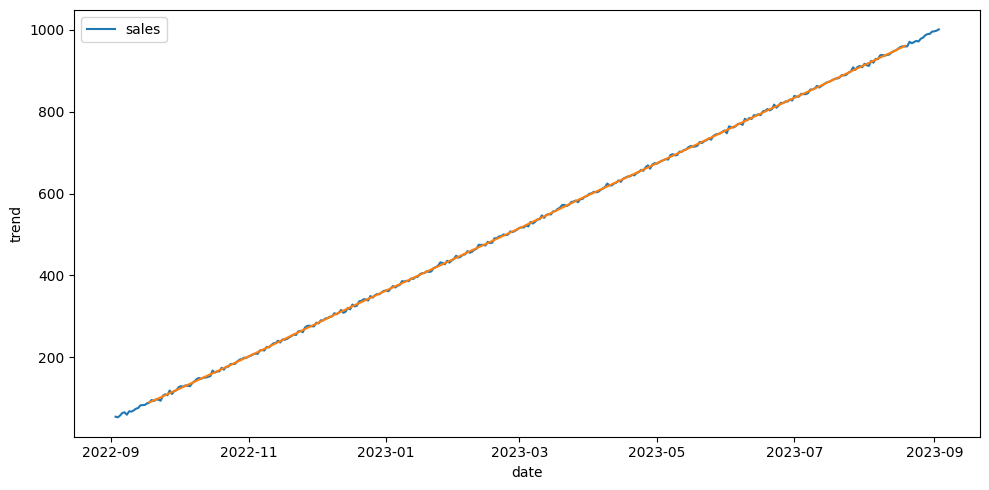

In [16]:
tendencia = decomposition.trend
plt.subplots(figsize=(10,5))
sns.lineplot(data=df)
sns.lineplot(data=tendencia)
plt.tight_layout()
plt.show()

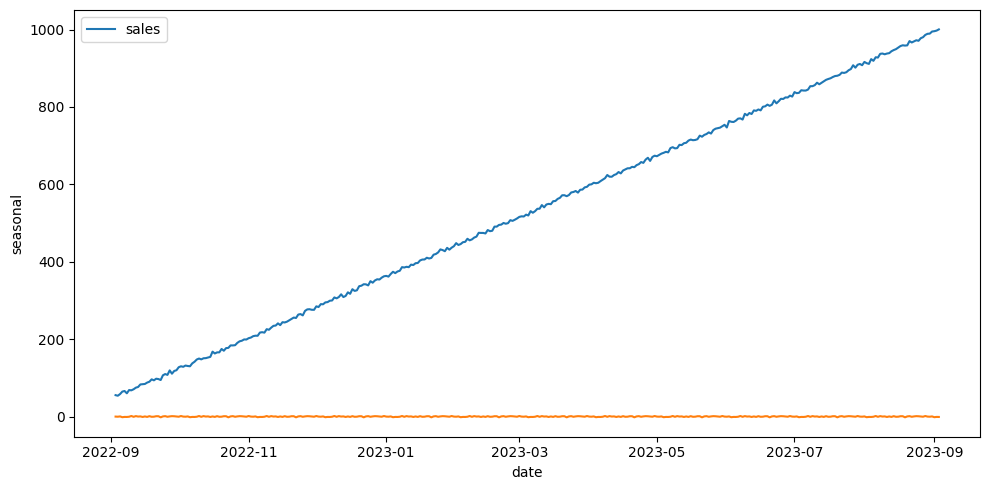

In [15]:
estacional = decomposition.seasonal
plt.subplots(figsize=(10,5))
sns.lineplot(data=df)
sns.lineplot(data=estacional)
plt.tight_layout()
plt.show()